# Change of Variable in HMC


**Rat tumor problem:** We have J certain kinds of rat tumor diseases. For each kind of tumor, we test $N_{j}$ people/animals and among those $y_{j}$ tested positive. Here we assume that $y_{j}$ is distrubuted with **Binom**($N_{i}$, $\theta_{i}$). Our objective is to approximate $\theta_{j}$ for each type of tumor.

In particular we use following binomial hierarchical model where $y_{j}$ and $N_{j}$ are observed variables.

```{math}
\begin{align}
    y_{j} &\sim \text{Binom}(N_{j}, \theta_{j}) \label{eq:1} \\
    \theta_{j} &\sim \text{Beta}(a, b) \label{eq:2} \\
    p(a, b) &\propto (a+b)^{-5/2}
\end{align}
```

In [1]:
import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option("display.max_rows", 80)

import blackjax
import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

plt.rc("xtick", labelsize=12)  # fontsize of the xtick labels
plt.rc("ytick", labelsize=12)  # fontsize of the tyick labels

In [2]:
# index of array is type of tumor and value shows number of total people tested.
group_size = jnp.array(
    [
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        19,
        19,
        19,
        19,
        18,
        18,
        17,
        20,
        20,
        20,
        20,
        19,
        19,
        18,
        18,
        25,
        24,
        23,
        20,
        20,
        20,
        20,
        20,
        20,
        10,
        49,
        19,
        46,
        27,
        17,
        49,
        47,
        20,
        20,
        13,
        48,
        50,
        20,
        20,
        20,
        20,
        20,
        20,
        20,
        48,
        19,
        19,
        19,
        22,
        46,
        49,
        20,
        20,
        23,
        19,
        22,
        20,
        20,
        20,
        52,
        46,
        47,
        24,
        14,
    ],
    dtype=jnp.float32,
)

# index of array is type of tumor and value shows number of positve people.
n_of_positives = jnp.array(
    [
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        0,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        2,
        2,
        2,
        2,
        2,
        2,
        2,
        2,
        2,
        1,
        5,
        2,
        5,
        3,
        2,
        7,
        7,
        3,
        3,
        2,
        9,
        10,
        4,
        4,
        4,
        4,
        4,
        4,
        4,
        10,
        4,
        4,
        4,
        5,
        11,
        12,
        5,
        5,
        6,
        5,
        6,
        6,
        6,
        6,
        16,
        15,
        15,
        9,
        4,
    ],
    dtype=jnp.float32,
)

# number of different kind of rat tumors
n_rat_tumors = len(group_size)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Text(0.5, 1.0, 'No. of positives for each tumor type')

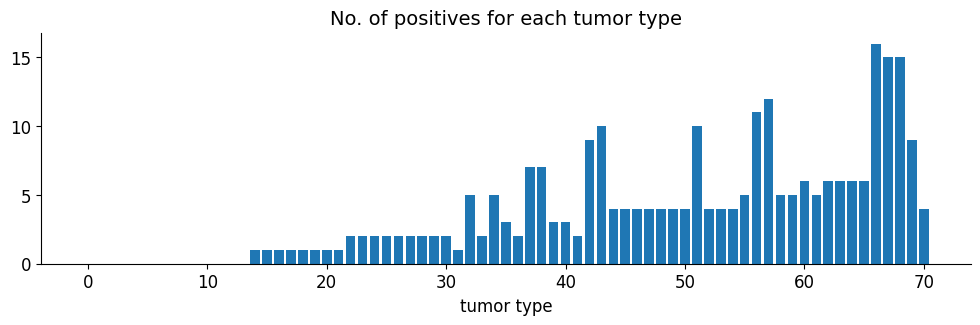

In [3]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.bar(range(n_rat_tumors), n_of_positives)

ax.set_xlabel("tumor type", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.title("No. of positives for each tumor type", fontsize=14)

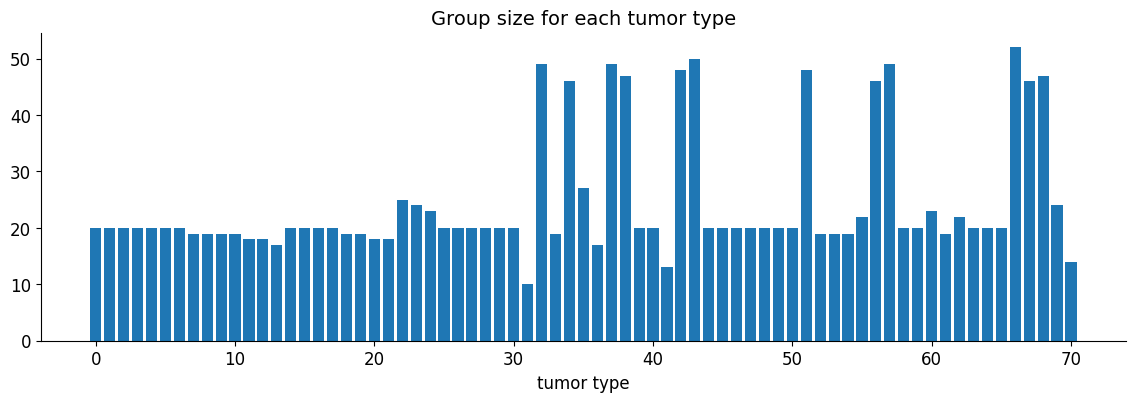

In [4]:
fig = plt.figure(figsize=(14, 4))
ax = fig.add_subplot(111)

ax.bar(range(n_rat_tumors), group_size)
plt.title("Group size for each tumor type", fontsize=14)

ax.set_xlabel("tumor type", fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

## Posterior Sampling

Now we use Blackjax's NUTS algorithm to get posterior samples of $a$, $b$, and $\theta$

In [5]:
from collections import namedtuple

params = namedtuple("model_params", ["a", "b", "thetas"])


def joint_logdensity(params):
    # improper prior for a,b
    logdensity_ab = jnp.log(jnp.power(params.a + params.b, -2.5))

    # logdensity prior of theta
    logdensity_thetas = tfd.Beta(params.a, params.b).log_prob(params.thetas).sum()

    # loglikelihood of y
    logdensity_y = jnp.sum(
        tfd.Binomial(group_size, probs=params.thetas).log_prob(n_of_positives)
    )

    return logdensity_ab + logdensity_thetas + logdensity_y

We take initial parameters from uniform distribution

In [6]:
rng_key = jax.random.PRNGKey(0)
n_params = n_rat_tumors + 2


def init_param_fn(seed):
    """
    initialize a, b & thetas
    """
    key1, key2, key3 = jax.random.split(seed, 3)
    return params(
        a=tfd.Uniform(0, 3).sample(seed=key1),
        b=tfd.Uniform(0, 3).sample(seed=key2),
        thetas=tfd.Uniform(0, 1).sample(n_rat_tumors, key3),
    )


init_param = init_param_fn(rng_key)
joint_logdensity(init_param)  # sanity check

Array(-1123.4977, dtype=float32)

Now we use blackjax's window adaption algorithm to get NUTS kernel and initial states. Window adaption algorithm will automatically configure `inverse_mass_matrix` and `step size`

In [7]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)

# we use 4 chains for sampling
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
init_params = jax.vmap(init_param_fn)(keys)

@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params

initial_states, tuned_params = jax.jit(call_warmup)(keys, init_params)

CPU times: user 13.3 s, sys: 104 ms, total: 13.4 s
Wall time: 13.3 s


Now we write inference loop for multiple chains

In [8]:
def inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, log_prob_fn, num_samples, num_chains
):
    step_fn = blackjax.nuts.kernel()

    def kernel(key, state, **params):
        return step_fn(key, state, log_prob_fn, **params)

    def one_step(states, rng_key):
        keys = jax.random.split(rng_key, num_chains)
        states, infos = jax.vmap(kernel)(keys, states, **tuned_params)
        return states, (states, infos)

    keys = jax.random.split(rng_key, num_samples)
    _, (states, infos) = jax.lax.scan(one_step, initial_states, keys)

    return (states, infos)

In [9]:
%%time
n_samples = 1000
states, infos = inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

CPU times: user 10.7 s, sys: 31.8 ms, total: 10.7 s
Wall time: 10.7 s


## Arviz Plots

We have all our posterior samples stored in `states.position` dictionary and `infos` store additional information like acceptance probability, divergence, etc. Now, we can use certain diagnostics to judge if our MCMC samples are converged on stationary distribution. Some of widely diagnostics are trace plots, potential scale reduction factor (R hat), divergences, etc. `Arviz` library provides quicker ways to anaylze these diagnostics. We can use `arviz.summary()` and `arviz_plot_trace()`, but these functions take specific format (arviz's trace) as a input.

In [10]:
def arviz_trace_from_states(states, info, burn_in=0):
    position = states.position
    if isinstance(position, jnp.DeviceArray):  # if states.position is array of samples
        position = dict(samples=position)
    else:
        try:
            position = position._asdict()
        except AttributeError:
            pass

    samples = {}
    for param in position.keys():
        ndims = len(position[param].shape)
        if ndims >= 2:
            samples[param] = jnp.swapaxes(position[param], 0, 1)[
                :, burn_in:
            ]  # swap n_samples and n_chains
            divergence = jnp.swapaxes(info.is_divergent[burn_in:], 0, 1)

        if ndims == 1:
            divergence = info.is_divergent
            samples[param] = position[param]

    trace_posterior = az.convert_to_inference_data(samples)
    trace_sample_stats = az.convert_to_inference_data(
        {"diverging": divergence}, group="sample_stats"
    )
    trace = az.concat(trace_posterior, trace_sample_stats)
    return trace

In [11]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.799,0.104,0.643,0.934,0.049,0.037,5.0,20.0,2.43
b,3.026,0.477,2.536,4.099,0.227,0.173,5.0,14.0,2.74
thetas[0],0.070,0.067,0.002,0.180,0.031,0.023,6.0,18.0,1.97
thetas[1],0.023,0.021,0.000,0.064,0.008,0.006,7.0,33.0,1.67
thetas[2],0.060,0.046,0.000,0.135,0.023,0.017,5.0,23.0,2.75
thetas[3],0.037,0.040,0.000,0.110,0.018,0.014,6.0,55.0,1.68
thetas[4],0.033,0.022,0.000,0.077,0.009,0.007,6.0,18.0,1.90
thetas[5],0.023,0.022,0.000,0.066,0.010,0.008,6.0,43.0,1.97
thetas[6],0.019,0.020,0.000,0.055,0.008,0.006,7.0,17.0,1.51
thetas[7],0.026,0.032,0.000,0.087,0.015,0.012,6.0,20.0,1.89


**r_hat** is showing measure of each chain is converged to stationary distribution. **r_hat** should be less than or equal to 1.01, here we get r_hat far from 1.01 for each latent sample.

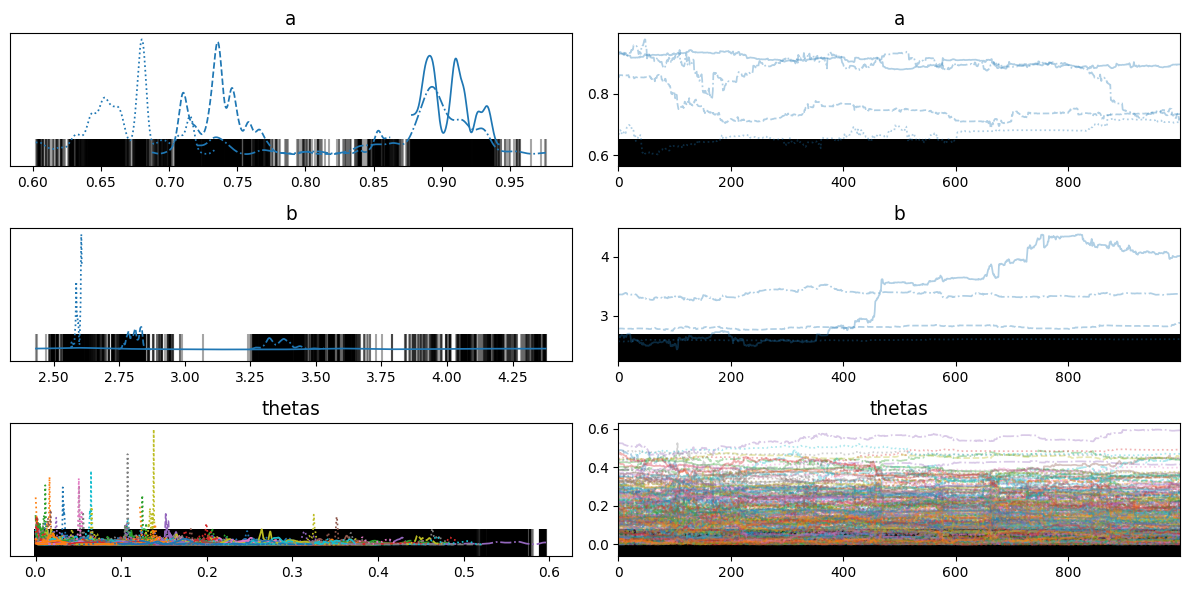

In [12]:
az.plot_trace(trace)
plt.tight_layout()

Trace plots also looks terrible and does not seems to be converged! Also, black band shows that every sample is diverged from original distribution. So **what's wrong happeing here?**

Well, it's related to support of latent variable. In HMC, the latent variable must be in an unconstrained space, but in above model `theta` is constrained in between 0 to 1. We can use change of variable trick to solve above problem

## Change of Variable
We can sample from logits which is in unconstrained space and in `joint_logdensity()` we can convert logits to theta by suitable bijector (sigmoid). We calculate jacobian (first order derivaive) of bijector to tranform one probability distribution to another

In [13]:
transform_fn = jax.nn.sigmoid
log_jacobian_fn = lambda logit: jnp.log(jnp.abs(jnp.diag(jax.jacfwd(transform_fn)(logit))))

Alternatively, using the bijector class in `TFP` directly:

In [14]:
bij = tfb.Sigmoid()
transform_fn = bij.forward
log_jacobian_fn = bij.forward_log_det_jacobian

In [15]:
params = namedtuple("model_params", ["a", "b", "logits"])

def joint_logdensity_change_of_var(params):
    # change of variable
    thetas = transform_fn(params.logits)
    log_det_jacob = jnp.sum(log_jacobian_fn(params.logits))

    # improper prior for a,b
    logdensity_ab = jnp.log(jnp.power(params.a + params.b, -2.5))

    # logdensity prior of theta
    logdensity_thetas = tfd.Beta(params.a, params.b).log_prob(thetas).sum()

    # loglikelihood of y
    logdensity_y = jnp.sum(
        tfd.Binomial(group_size, probs=thetas).log_prob(n_of_positives)
    )

    return logdensity_ab + logdensity_thetas + logdensity_y + log_det_jacob

except for the change of variable in `joint_logdensity()` function, everthing will remain same

In [16]:
rng_key = jax.random.PRNGKey(0)


def init_param_fn(seed):
    """
    initialize a, b & logits
    """
    key1, key2, key3 = jax.random.split(seed, 3)
    return params(
        a=tfd.Uniform(0, 3).sample(seed=key1),
        b=tfd.Uniform(0, 3).sample(seed=key2),
        logits=tfd.Uniform(-2, 2).sample(n_rat_tumors, key3),
    )


init_param = init_param_fn(rng_key)
joint_logdensity_change_of_var(init_param)  # sanity check

Array(-1022.78735, dtype=float32)

In [17]:
%%time
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity_change_of_var)

# we use 4 chains for sampling
n_chains = 4
keys = jax.random.split(rng_key, n_chains)
init_params = jax.vmap(init_param_fn)(keys)

@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params

initial_states, tuned_params = call_warmup(keys, init_params)

CPU times: user 14.6 s, sys: 48 ms, total: 14.7 s
Wall time: 14.7 s


In [18]:
%%time
n_samples = 1000
states, infos = inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, joint_logdensity_change_of_var, n_samples, n_chains
)

CPU times: user 10.1 s, sys: 32 ms, total: 10.2 s
Wall time: 10.2 s


In [19]:
# convert logits samples to theta samples
position = states.position._asdict()
position["thetas"] = jax.nn.sigmoid(position["logits"])
del position["logits"]  # delete logits
states = states._replace(position=position)

In [20]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos, burn_in=0)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.430,0.932,1.119,4.190,0.043,0.032,567.0,569.0,1.01
b,14.481,5.518,5.927,24.235,0.244,0.181,617.0,615.0,1.01
thetas[0],0.063,0.042,0.002,0.140,0.001,0.000,3032.0,2041.0,1.00
thetas[1],0.064,0.042,0.002,0.138,0.001,0.000,2905.0,2080.0,1.00
thetas[2],0.063,0.041,0.001,0.136,0.001,0.000,3025.0,2487.0,1.00
thetas[3],0.065,0.043,0.001,0.139,0.001,0.001,3200.0,2053.0,1.00
thetas[4],0.065,0.041,0.001,0.136,0.001,0.001,2589.0,1974.0,1.00
thetas[5],0.064,0.041,0.003,0.138,0.001,0.000,2949.0,2287.0,1.00
thetas[6],0.064,0.040,0.001,0.136,0.001,0.001,2399.0,1983.0,1.00
thetas[7],0.065,0.042,0.002,0.141,0.001,0.001,2521.0,1741.0,1.00


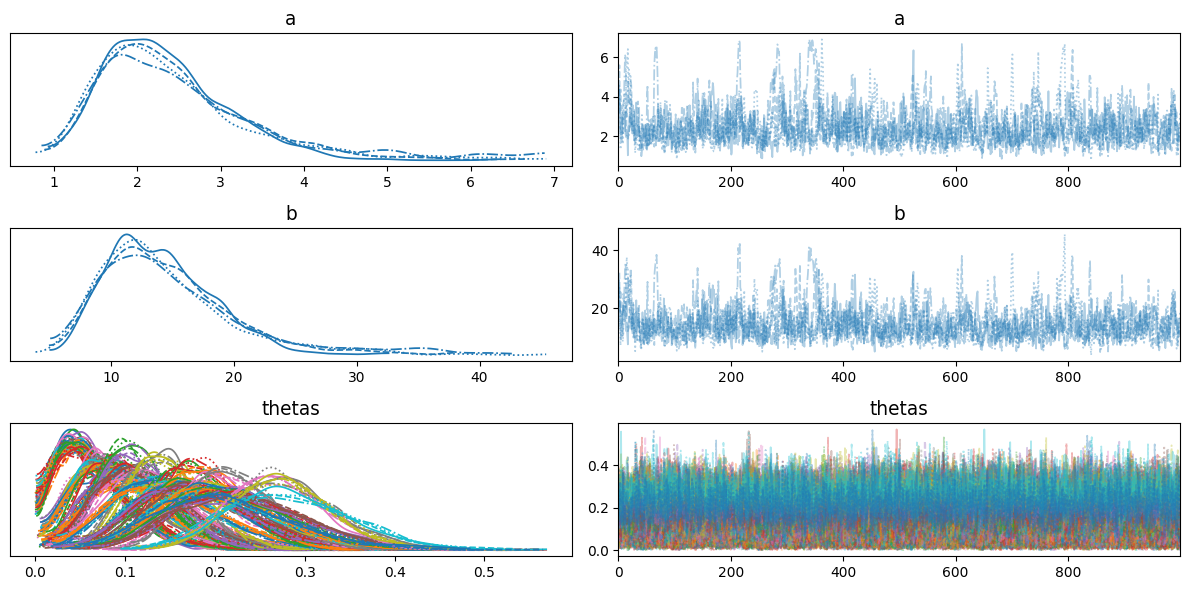

In [21]:
az.plot_trace(trace)
plt.tight_layout()

In [22]:
print(f"Number of divergence: {infos.is_divergent.sum()}")

Number of divergence: 0


We can see that **r_hat** is less than or equal to 1.01 for each latent variable, trace plots looks converged to stationary distribution, and only few samples are diverged.

## Using a PPL

Probabilistic programming language usually provides functionality to apply change of variable easily (often done automatically). In this case for TFP, we can use its modeling API `tfd.JointDistribution*`.

In [23]:
tfed = tfp.experimental.distributions

@tfd.JointDistributionCoroutineAutoBatched
def model():
    # TFP does not have improper prior, use uninformative prior instead
    a = yield tfd.HalfCauchy(0, 100, name='a')
    b = yield tfd.HalfCauchy(0, 100, name='b')
    yield tfed.IncrementLogProb(jnp.log(jnp.power(a + b, -2.5)), name='logdensity_ab')

    thetas = yield tfd.Sample(tfd.Beta(a, b), n_rat_tumors, name='thetas')
    yield tfd.Binomial(group_size, probs=thetas, name='y')

# Sample from the prior and prior predictive distributions. The result is a pytree.
# model.sample(seed=rng_key)

In [24]:
# Condition on the observed (and auxiliary variable).
pinned = model.experimental_pin(logdensity_ab=(), y=n_of_positives)
# Get the default change of variable bijectors from the model
bijectors = pinned.experimental_default_event_space_bijector()

prior_sample = pinned.sample_unpinned(seed=rng_key)
# You can check the unbounded sample
# bijectors.inverse(prior_sample)

In [25]:
def joint_logdensity(unbound_param):
    param = bijectors.forward(unbound_param)
    log_det_jacobian = bijectors.forward_log_det_jacobian(unbound_param)
    return pinned.unnormalized_log_prob(param) + log_det_jacobian

In [26]:
%%time
rng_key = jax.random.PRNGKey(0)
warmup = blackjax.window_adaptation(blackjax.nuts, joint_logdensity)

# we use 4 chains for sampling
n_chains = 4
init_key, warmup_key = jax.random.split(rng_key, 2)
init_params = bijectors.inverse(pinned.sample_unpinned(n_chains, seed=init_key))

keys = jax.random.split(warmup_key, n_chains)

@jax.vmap
def call_warmup(seed, param):
    (initial_states, tuned_params), _ = warmup.run(seed, param, 1000)
    return initial_states, tuned_params

initial_states, tuned_params = call_warmup(keys, init_params)

CPU times: user 17.9 s, sys: 100 ms, total: 18 s
Wall time: 18 s


In [27]:
%%time
n_samples = 1000
states, infos = inference_loop_multiple_chains(
    rng_key, initial_states, tuned_params, joint_logdensity, n_samples, n_chains
)

CPU times: user 11.2 s, sys: 56.1 ms, total: 11.3 s
Wall time: 11.3 s


In [28]:
# convert logits samples to theta samples
position = states.position
states = states._replace(position=bijectors.forward(position))

In [29]:
# make arviz trace from states
trace = arviz_trace_from_states(states, infos, burn_in=0)
summ_df = az.summary(trace)
summ_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,2.394,0.903,1.029,4.030,0.037,0.027,689.0,910.0,1.00
b,14.266,5.399,6.517,24.617,0.220,0.160,701.0,831.0,1.00
thetas[0],0.063,0.042,0.002,0.140,0.001,0.000,3234.0,1971.0,1.00
thetas[1],0.064,0.043,0.000,0.141,0.001,0.000,3336.0,2037.0,1.00
thetas[2],0.063,0.042,0.001,0.138,0.001,0.001,2981.0,2202.0,1.00
thetas[3],0.064,0.042,0.001,0.137,0.001,0.001,3031.0,2310.0,1.00
thetas[4],0.063,0.041,0.002,0.134,0.001,0.000,2862.0,1826.0,1.00
thetas[5],0.063,0.041,0.002,0.139,0.001,0.000,2928.0,1915.0,1.00
thetas[6],0.064,0.042,0.001,0.139,0.001,0.000,2879.0,2188.0,1.00
thetas[7],0.065,0.042,0.002,0.140,0.001,0.000,2803.0,2128.0,1.00


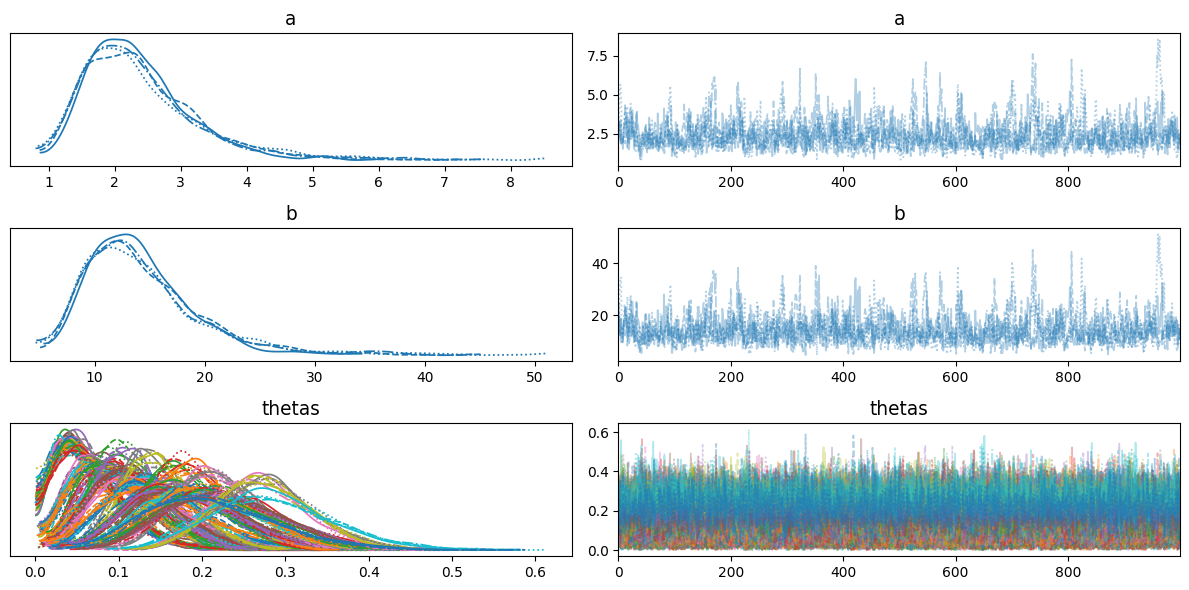

In [30]:
az.plot_trace(trace)
plt.tight_layout()